# Assignment: Visualization
### `! git clone https://github.com/ds3001f25/visualization_assignment.git`
### Do Q1 and Q2.

In [43]:
! git clone https://github.com/ds3001f25/visualization_assignment.git

Cloning into 'visualization_assignment'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 7 (from 1)
Receiving objects: 100% (10/10), 1.88 MiB | 6.47 MiB/s, done.


In [44]:
cd visualization_assignment/

/content/visualization_assignment/data/visualization_assignment


In [45]:
%cd data/

/content/visualization_assignment/data/visualization_assignment/data


In [46]:
ls -al

total 4820
drwxr-xr-x 2 root root    4096 Sep 16 02:37 ./
drwxr-xr-x 4 root root    4096 Sep 16 02:37 ../
-rw-r--r-- 1 root root 1694435 Sep 16 02:37 college_completion.csv
-rw-r--r-- 1 root root 1646175 Sep 16 02:37 pretrial_data.csv
-rw-r--r-- 1 root root 1582160 Sep 16 02:37 VirginiaPretrialData2017Codebook.pdf


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Q1.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use the pretrail data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform
$$
k(z) = \begin{cases}
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is
$$
k(z) = \begin{cases}
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.

In [38]:
pretrial = pd.read_csv('pretrial_data.csv')
print(pretrial.columns)

Index(['Unnamed: 0', 'case_type', 'age', 'sex', 'race', 'is_poor', 'bond',
       'bond_type', 'prior_F', 'prior_M', 'gini', 'released', 'sentence_type',
       'sentence', 'bond_NA', 'held_wo_bail', 'sentence_NA'],
      dtype='object')


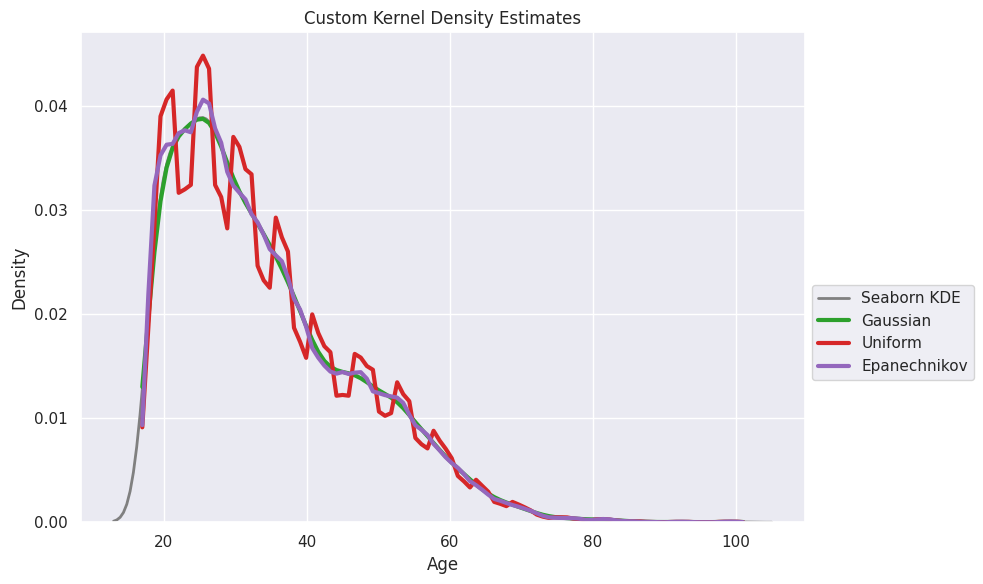

In [67]:
from scipy.spatial.distance import cdist
# using cdist to avoid double for loops, which were time consuming and required
# more complex functions

def silverman_bandwidth(data_array):
    n = len(data_array)
    # silverman bandwidth rule: 1.06 * std deviation * n^(-1/5)
    # chose silverman because it is a classical rule of thumb
    return 1.06 * np.std(data_array, ddof=1) * n ** (-1/5)

def gaussian_kernel_func(z_vals):
    # gaussian kernel formula
    # vectorized for speed over for-loop: returns density values for array of z
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z_vals ** 2)

def uniform_kernel_func(z_vals):
    # uniform kernel: flat within [-1,1], zero elsewhere
    # used np.where for fast vectorized conditional assignment instead of looping
    return np.where(np.abs(z_vals) <= 1, 0.5, 0.0)

def epanechnikov_kernel_func(z_vals):
    # epanechnikov kernel defined on [-1,1]
    # also vectorized using np.where for efficiency
    return np.where(np.abs(z_vals) <= 1, 0.75 * (1 - z_vals ** 2), 0.0)

# main driver function to calculate kernel density estimate
# accepts numpy array or list for data, optional evaluation points, plus
# kernel choice and bandwidth
# default kernel is gaussian for smoothness, bw defaults to silverman bandwidth rule
def kernel_density_estimator(data_input, eval_points=None, kernel='gaussian', bandwidth=None):
    # convert input data to numpy array of floats for consistency
    array_data = np.asarray(data_input).astype(float)
    n = len(array_data)
    # if no grid points provided, generate 100 points over min/max range
    # extension by 1 prevents edge problem in density plot near min/max values
    if eval_points is None:
        eval_points = np.linspace(np.min(array_data)-1, np.max(array_data)+1, 100)
    else:
        # convert points to numpy array if given
        eval_points = np.asarray(eval_points)
    # calculate bandwidth if not provided using silverman's rule
    if bandwidth is None:
        bandwidth = silverman_bandwidth(array_data)

    # define kernel function dictionary for ease and clean selection
    kernel_functions = {
        'gaussian': gaussian_kernel_func,
        'uniform': uniform_kernel_func,
        'epanechnikov': epanechnikov_kernel_func}

    # select kernel function based on user input
    kernel_function = kernel_functions[kernel]

    # standardize distances of evaluation points from data by bandwidth
    # used broadcasting instead of loops for efficiency- loops were complicated
    # and time consuming
    z_vals = (eval_points[:, None] - array_data[None, :]) / bandwidth

    # evaluate kernel function at each (evaluation point - data point)
    # scaled by bw
    kernel_values = kernel_function(z_vals)

    # compute density estimate by summing kernel values and normalizing by n * bw
    # np.sum used over mean to explicitly follow kde formula dividing by total
    # n and bandwidth
    density_estimate = np.sum(kernel_values, axis=1) / (n * bandwidth)

    # return evaluation points and their estimated densities
    return eval_points, density_estimate

# extract 'age' column from pretrial data, drop missing values, convert to float
age = pretrial['age'].dropna().values.astype(float)

# list of kernels to plot for comparison (variable name changed)
kerns_plt = ['gaussian', 'uniform', 'epanechnikov']
# changed colors for fresh look with different palette
colors = {'gaussian': '#2ca02c', 'uniform': '#d62728', 'epanechnikov': '#9467bd'}

# setting seaborn style for plot background and aesthetics
sns.set_theme(style="darkgrid")

plt.figure(figsize=(10,6))

# plot seaborn kde as baseline for comparison - lighter gray for contrast
sns.kdeplot(age, fill=False, color='gray', linewidth=2, label='Seaborn KDE')

# loop over kernels and plot our custom kde function results
# used kernel_density_estimator to generate density values for each kernel
# capitalize labels for presentation, colors from predefined dict
# linewidth increased for visibility
# removed linestyle to have solid lines- originally they were dashed
for kernel in kerns_plt:
    xs, ys = kernel_density_estimator(age, kernel=kernel)
    plt.plot(xs, ys, label=kernel.capitalize(), color=colors[kernel], linewidth=3)

# labeling for clarity: x axis, y axis and plot title
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Custom Kernel Density Estimates')

# place legend outside the plot area on the upper left
# this keeps plot uncluttered especially with multiple lines
plt.legend(loc='upper left', bbox_to_anchor=(1,0.5))

plt.tight_layout()
plt.show()


**Q2.** This question provides some practice doing exploratory data analysis and visualization.

The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `./data/college_completion.csv` data with Pandas.
2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see.
4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.
5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?
6. Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.
8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?

2.1

In [9]:
college = pd.read_csv('college_completion.csv')

2.2

In [10]:
college.head()

,index,unitid,chronname,city,state,level,control,basic,hbcu,flagship,...,vsa_grad_after6_transfer,vsa_grad_elsewhere_after6_transfer,vsa_enroll_after6_transfer,vsa_enroll_elsewhere_after6_transfer,similar,state_sector_ct,carnegie_ct,counted_pct,nicknames,cohort_size
0,0,100654,Alabama A&M University,Normal,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,36.4,5.6,17.2,11.1,232937|100724|405997|113607|139533|144005|2285...,13,386,99.7|07,NaN,882.0
1,1,100663,University of Alabama at Birmingham,Birmingham,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,NaN,NaN,NaN,NaN,196060|180461|201885|145600|209542|236939|1268...,13,106,56.0|07,UAB,1376.0
2,2,100690,Amridge University,Montgomery,Alabama,4-year,Private not-for-profit,Baccalaureate Colleges--Arts & Sciences,NaN,NaN,...,NaN,NaN,NaN,NaN,217925|441511|205124|247825|197647|221856|1353...,16,252,100.0|07,NaN,3.0
3,3,100706,University of Alabama at Huntsville,Huntsville,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,0.0,0.0,0.0,0.0,232186|133881|196103|196413|207388|171128|1900...,13,106,43.1|07,UAH,759.0
4,4,100724,Alabama State University,Montgomery,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,NaN,NaN,NaN,NaN,100654|232937|242617|243197|144005|241739|2354...,13,386,88.0|07,ASU,1351.0


In [11]:
print(college.shape)
print(college.columns)

# dimensions are 63 columns by 3798 observations; columns are listed in the
# printed code block

(3798, 63)
Index(['index', 'unitid', 'chronname', 'city', 'state', 'level', 'control',
       'basic', 'hbcu', 'flagship', 'long_x', 'lat_y', 'site', 'student_count',
       'awards_per_value', 'awards_per_state_value', 'awards_per_natl_value',
       'exp_award_value', 'exp_award_state_value', 'exp_award_natl_value',
       'exp_award_percentile', 'ft_pct', 'fte_value', 'fte_percentile',
       'med_sat_value', 'med_sat_percentile', 'aid_value', 'aid_percentile',
       'endow_value', 'endow_percentile', 'grad_100_value',
       'grad_100_percentile', 'grad_150_value', 'grad_150_percentile',
       'pell_value', 'pell_percentile', 'retain_value', 'retain_percentile',
       'ft_fac_value', 'ft_fac_percentile', 'vsa_year',
       'vsa_grad_after4_first', 'vsa_grad_elsewhere_after4_first',
       'vsa_enroll_after4_first', 'vsa_enroll_elsewhere_after4_first',
       'vsa_grad_after6_first', 'vsa_grad_elsewhere_after6_first',
       'vsa_enroll_after6_first', 'vsa_enroll_elsewhere_after6

2.3

In [12]:
pd.crosstab(college['control'], college['level'])

# Public institutions have the most 2-year programs, which makes sense given that
# most community colleges (2-year programs) are public. The type of institution
# with the lowest proportion of 2-year programs are not-for-profit private
# universities- this is reasonable because private not-for-profit institutions
# tend to be more selective.

level,2-year,4-year
control,,
Private for-profit,465,527
Private not-for-profit,68,1180
Public,926,632


2.4

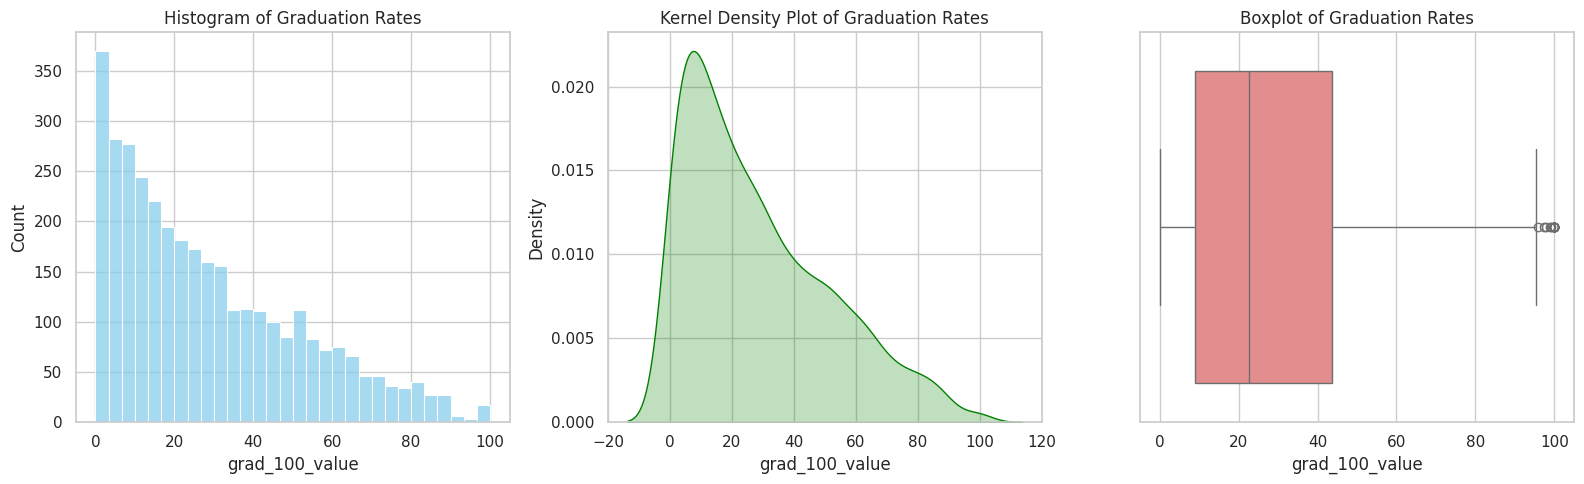

count    3467.000000
mean       28.364465
std        23.312730
min         0.000000
25%         9.000000
50%        22.500000
75%        43.650000
max       100.000000
Name: grad_100_value, dtype: float64


In [13]:
# setting up a seaborn style
sns.set(style="whitegrid")

# setting up a single figure with all of the plots on it
plt.figure(figsize=(16, 5))

# histogram
plt.subplot(1, 3, 1) # arranging subplot position
sns.histplot(college['grad_100_value'].dropna(), kde=False, bins=30, color='skyblue')
plt.title('Histogram of Graduation Rates')
plt.xlabel('grad_100_value')

# kde
plt.subplot(1, 3, 2) # arranging subplot position
sns.kdeplot(college['grad_100_value'].dropna(), fill=True, color='green')
plt.title('Kernel Density Plot of Graduation Rates')
plt.xlabel('grad_100_value')

# boxplot
plt.subplot(1, 3, 3) # arranging subplot position
sns.boxplot(x=college['grad_100_value'], color='lightcoral')
plt.title('Boxplot of Graduation Rates')
plt.xlabel('grad_100_value')

plt.tight_layout()
plt.show()

# statistical description
print(college['grad_100_value'].describe())

2.5

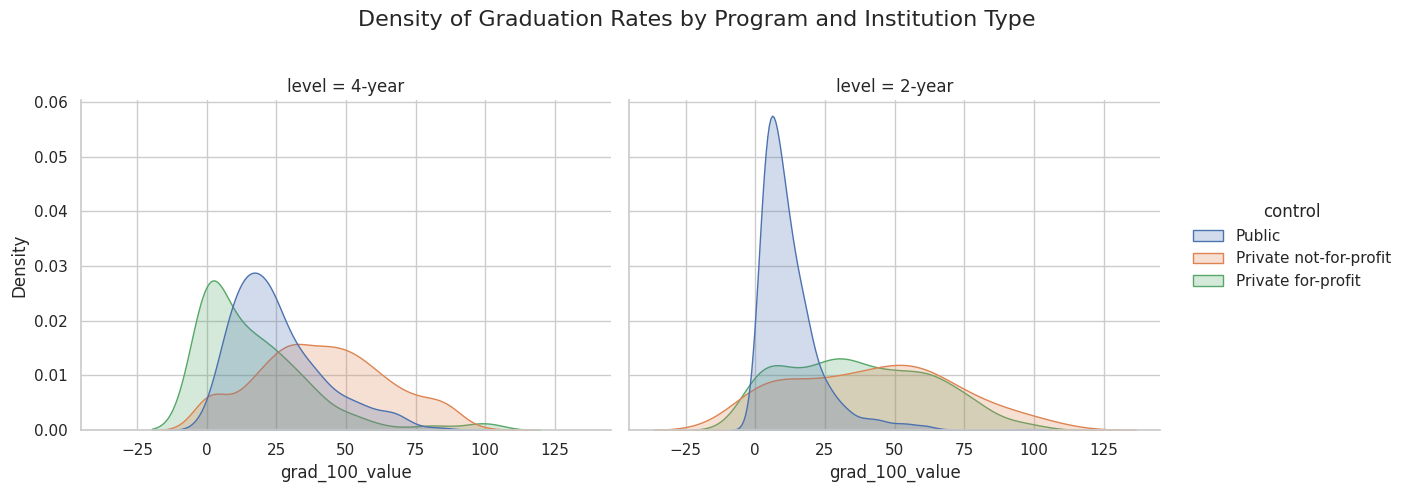

                                count       mean        std  min     25%  \
level  control                                                             
2-year Private for-profit       461.0  37.197614  25.497380  0.0  15.800   
       Private not-for-profit    68.0  41.913235  28.348302  0.0  16.225   
       Public                   926.0  12.400000  10.893600  0.0   5.100   
4-year Private for-profit       318.0  17.382704  20.788525  0.0   0.000   
       Private not-for-profit  1121.0  41.645674  23.243453  0.0  25.000   
       Public                   573.0  25.561082  16.403902  0.0  13.600   

                                50%     75%    max  
level  control                                      
2-year Private for-profit      33.9  57.800  100.0  
       Private not-for-profit  44.4  61.200  100.0  
       Public                   9.4  16.175   97.8  
4-year Private for-profit      12.5  26.325  100.0  
       Private not-for-profit  41.0  57.800  100.0  
       Public       

In [14]:
# Drop rows with missing required values
college_grp = college.dropna(subset=['grad_100_value', 'control', 'level'])

# creating one plot with two sub KDEs, one for 2-year institutions and one for
# 4-year institutions that will be side by side
sns.displot(
    data=college_grp,
    x='grad_100_value',
    kind='kde',
    hue='control', # color indicates institution type
    col='level',
    fill=True,
    common_norm=False, # makes it so that each KDE is scaled independently
    height=5,
    aspect=1.2
)

# titles and labels
plt.subplots_adjust(top=0.8)
plt.suptitle('Density of Graduation Rates by Program and Institution Type', fontsize=16)
plt.show()

# statistical description
print(college.groupby(['level', 'control'])['grad_100_value'].describe())

# These KDEs reveal that, as predicted, graduation rates are much lower for 2-year
# programs than 4-year programs, especially for public 2-year institutions, which
# are typically community colleges. Graduation rates are highest for private
# not-for-profit universities, both for 2- and 4-year programs. This conclusion
# is reflected both in the density plot and the grouped statistical description
# of the data, where the mean and median graduation rate is highest for private
# not-for-profit institutions.

2.6

/tmp/ipython-input-1597634796.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  college_grp['levelXcontrol'] = college_grp['level']+', ' + college_grp['control']


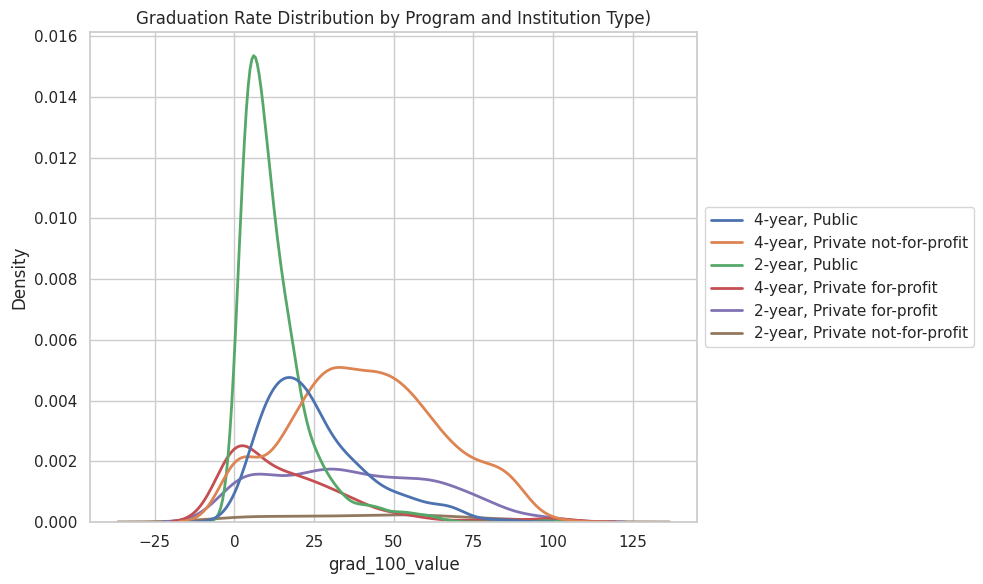

In [15]:
college_grp['levelXcontrol'] = college_grp['level']+', ' + college_grp['control']

plt.figure(figsize=(10, 6))
ax = sns.kdeplot(
    data=college_grp,
    x='grad_100_value',
    hue='levelXcontrol',
    linewidth=2,
    legend=False)  # disable seaborn's automatic legend
    # if I don't disable it it puts the legend on top of the graph or it's
    # empty for some reason- so have to do this

plt.title('Graduation Rate Distribution by Program and Institution Type)')
plt.xlabel('grad_100_value')
plt.ylabel('Density')

# manually recreate legend
levels = college_grp['levelXcontrol'].unique() # pulls every category
colors = sns.color_palette(n_colors=len(levels)) # gives them a unique color

# used AI to figure this section out, which creates proxy artists for the legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=colors[i], lw=2, label=levels[i]) for i in range(len(levels))]

# anchoring legend to the right of the graph
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Now, with this graph, it still appears that 4-year, not for profit institutions
# have the highest graduation rates. They have the highest density of higher
# graduation rates. It seems that second to them are 2-year, private for profit
# institutions, which is surprising to me.

2.7

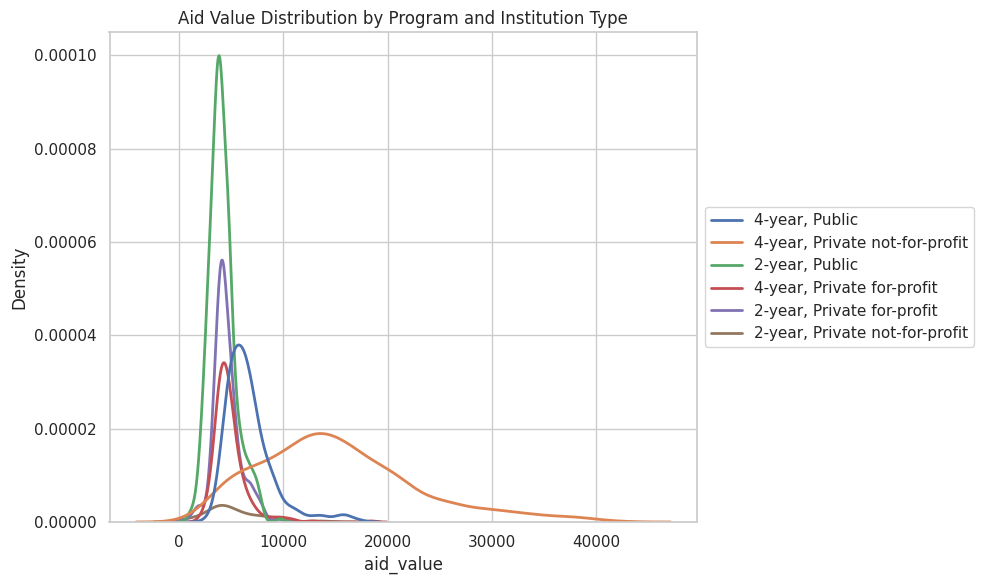

In [16]:
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(
    data=college_grp,
    x='aid_value',
    hue='levelXcontrol', # sorting aid value by ins and program type
    linewidth=2,
    legend=False) # using same method as in 2.6 to manually input the legend
    # otherwise it will overlap with the graph or it will be empty

plt.title('Aid Value Distribution by Program and Institution Type')
plt.xlabel('aid_value')
plt.ylabel('Density')

levels = college_grp['levelXcontrol'].unique()
colors = sns.color_palette(n_colors=len(levels))

# similar method to above in order to craft legend; used discord and AI (GPT-5)
# for help with this line
legend_elements = list(map(lambda c_l: Line2D([0], [0], color=c_l[0], lw=2,
                                              label=c_l[1]), zip(colors, levels)))

# locking legend to the right of the graph
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Something that explains the shape of the graph might be differing costs of
# education and the value of the education at different institutions. It seems
# that the 2-year, public group has the lowest amount of aid received by under-
# graduate students. Because many community colleges are already low-cost and
# publicly funded, they might not give out much aid. The institutions that are
# most expensive (private four year programs) might encourage more students to
# apply for more aid because they are, by definition, more expensive.

In [71]:
print(college_grp.groupby(['level', 'control'])['aid_value'].describe())

                                count          mean          std     min  \
level  control                                                             
2-year Private for-profit       460.0   4548.886957  1273.908071   294.0   
       Private not-for-profit    68.0   5128.058824  2590.449946   934.0   
       Public                   926.0   4126.199784  1260.271382   881.0   
4-year Private for-profit       318.0   4829.050314  1620.406400  2217.0   
       Private not-for-profit  1121.0  15111.199822  7549.163907  1450.0   
       Public                   573.0   6717.588133  2345.658634  2685.0   

                                   25%      50%       75%      max  
level  control                                                      
2-year Private for-profit      3814.75   4286.5   5104.25   9727.0  
       Private not-for-profit  3650.00   4516.5   6311.50  13654.0  
       Public                  3311.25   3943.5   4762.00   9809.0  
4-year Private for-profit      3908.00   4491.

2.8

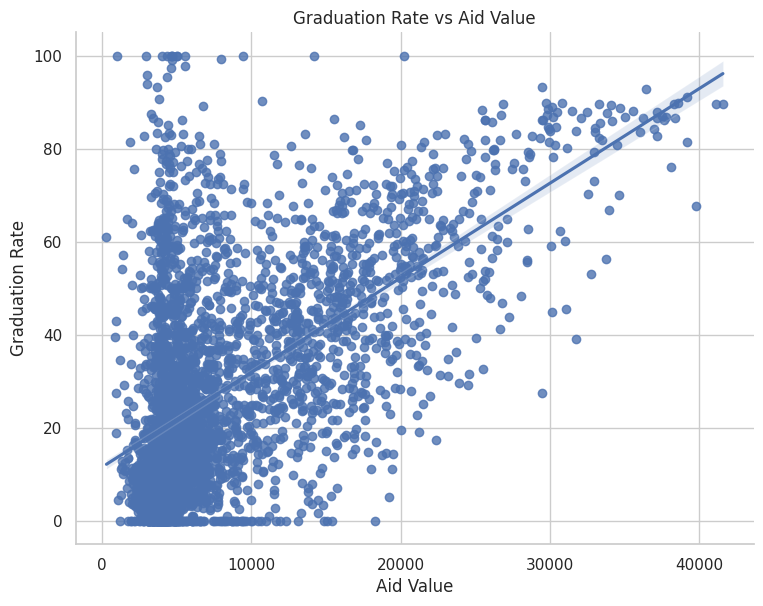

In [17]:
sns.lmplot(data=college, x='aid_value', y='grad_100_value', height=6, aspect=1.3)
plt.title('Graduation Rate vs Aid Value')
plt.xlabel('Aid Value')
plt.ylabel('Graduation Rate')
plt.show()

# On this graph, I see a positive correlation between graduation rate and aid
# value. Institutions with higher graduation rates appear to award more aid per
# student. This tracks with the understanding from previous graphs that private,
# not for profit universities have the highest graduation rates AND award the
# most aid.

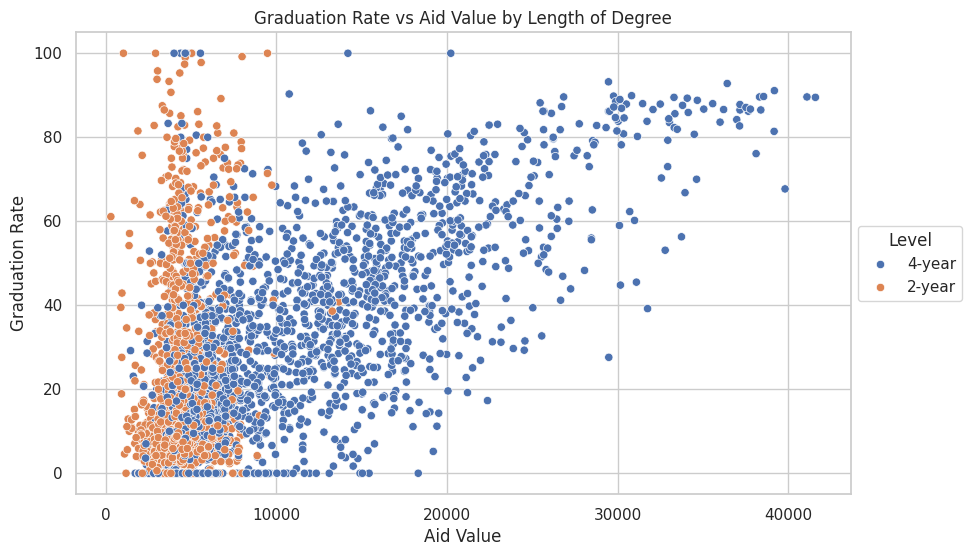

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=college, x='aid_value', y='grad_100_value', hue='level')
plt.title('Graduation Rate vs Aid Value by Length of Degree')
plt.xlabel('Aid Value')
plt.ylabel('Graduation Rate')
plt.legend(title='Level', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Aid increases the graduation rate for 4-year institutions, but not for 2-year
# ones. It appears to be the case that aid is rarely awarded to students in 2-year
# programs, therefore it does not have an observable impact on graduation rate.

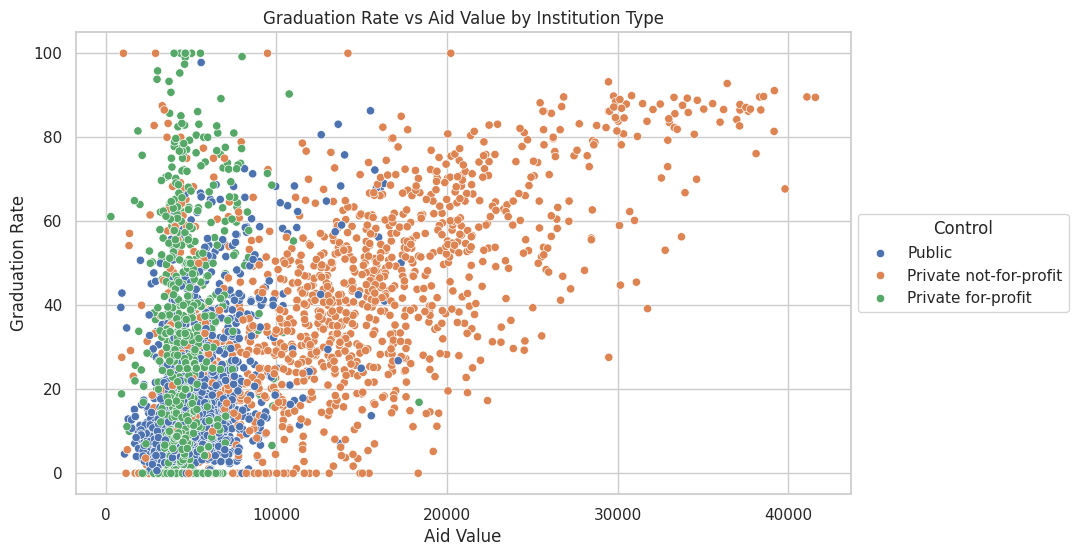

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=college, x='aid_value', y='grad_100_value', hue='control')
plt.title('Graduation Rate vs Aid Value by Institution Type')
plt.xlabel('Aid Value')
plt.ylabel('Graduation Rate')
plt.legend(title='Control', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Aid seems to increase graduation rates for both public universities and private
# not for profit universities. Private for-profit institutions appear not to give
# much aid at all, whereas for the other types of institutions there is a corre-
# lation between aid value and graduation rate.